In [28]:
# importing necessary modules.
import pandas as pd
import config as cfg
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [29]:
# creating a connection to an aws rds postgres cloud database.
rds_connection_string = f'postgres:{cfg.password}@test-db.cy2enoewwvsi.us-east-2.rds.amazonaws.com:5432/stocks_db'
engine = create_engine(f'postgres://{rds_connection_string}')

In [30]:
# checking out the table names in the database.
engine.table_names()

['sandp', 'russell_2000', 'sandp_russell', 'new_route']

In [31]:
# checking out the SandP_500 table.
sandp = pd.read_sql_query('SELECT * FROM sandp', con=engine)
sandp

,symbol,name,price_to_bookvalue,price_to_book,price_to_sales,price_to_earnings,receivables_turnover,price_to_free_cash_flow,price_to_operating_cash_flow,enterprise_value_multiple,gross_profit_margin,pretax_profit_margin,net_profit_margin,tax_rate,return_on_assets,return_on_equity,return_on_capital_employed,receivables_turnover_1,payables_turnover,inventory_turnover,fixed_asset_turnover,asset_turnover,current_ratio,quick_ratio,cash_ratio,days_of_sales_outstanding,days_of_inventory_outstanding,operating_cycle,days_of_payables_outstanding,cash_conversion_cycle,debt_ratio,debt_to_equity_ratio,longterm_debt_to_capitalization,total_debt_to_capitalization,interest_coverage,cash_flow_to_debt,company_equity_multiplier,operating_cash_flow_per_share,free_cash_flow_per_share,cash_per_share,payout_ratio,receivables_turnover_2,operating_cash_flow_to_sales,free_cash_flow_to_operating_cash_flow,cash_flow_coverage_ratio,short_term_coverage_ratio,capital_expenditure_coverage_ratio,dividend_capex_coverage_ratio,dividend_payout_ratio,gross_profit_growth,ebit_growth,operating_income_growth,net_income_growth,eps_growth,eps_diluted_growth,weighted_average_share_growth,weighted_averages_shares_diluted_growth,dividents_per_share_growth,operating_cash_flow_growth,free_cash_flow_growth,ten_year_revenue_growth_per_share,five_year_revenue_growth_per_share,three_year_revenue_growth_per_share,ten_year_operating_cf_growth_per_share,five_year_operating_cf_growth_per_share,three_year_operating_cf_growth_per_share,ten_year_net_income_growth_per_share,five_year_net_income_growth_per_share,three_year_net_income_growth_per_share,ten_year_shareholders_equity_growth_per_share,five_year_shareholders_equity_growth_per_share,three_year_shareholders_equity_growth_per_share,ten_year_dividend_growth_per_share,five_year_dividend_growth_per_share,three_year_dividend_growth_per_share,receivables_growh,inventory_growth,asset_growth,book_value_per_share_growth,debt_growth,randd_expense_growth,sganda_expense_growth,percent_return_on_investment,above_below_sandp_return,market_cap,industry,sector
0,A,"Agilent Technologies, Inc.",2.55170,5.17165,1.48130,6.30885,7.00140,18.18070,13.57995,16.746223,0.524850,0.057228,0.059362,2.720066,0.07990,0.09975,0.05130,7.00140,3.85290,8.03380,5.429030,0.575072,2.7640,2.894055,2.481972,-97.99795,53.36445,-99.00000,29.23140,-99.00000,0.38115,1.15130,0.470496,0.535164,4.64390,0.167487,3.020614,1.62420,1.27630,11.89585,-99.0000,7.00140,0.111470,0.764976,0.167487,204.239174,4.755422,4.755422,-99.000000,-0.00225,3.19800,5.05085,11.00990,10.92090,10.75375,-0.02195,-0.02360,-99.00000,0.14975,0.30285,-0.03010,0.08565,0.04200,0.04210,-0.00300,-0.06355,0.00790,0.12195,0.03385,-0.02165,0.01000,-0.00400,-99.00000,-99.00000,-99.00000,0.11660,0.07580,0.18005,0.15185,0.31885,-0.06740,0.01880,215.407785,1,7.462700e+09,Medical Diagnostics & Research,Healthcare
1,AAL,"American Airlines Group, Inc.",-99.00000,-99.00000,0.11565,-99.00000,27.33480,-99.00000,2.20925,61.812855,0.495744,-0.018258,-0.047475,-99.000000,-0.06890,0.27010,-0.01520,27.33480,5.02710,37.66910,1.378462,0.833326,0.8190,0.687756,0.074855,-19.81890,13.11230,-99.00000,19.26545,-99.00000,0.45185,-3.08765,1.617521,1.486838,-0.48480,0.095474,-99.000000,3.26045,-1.85000,1.84910,-99.0000,27.33480,0.051335,-0.565762,0.095474,0.746942,0.638704,0.638704,-99.000000,0.03935,0.77400,0.88765,0.49305,0.55295,0.55295,0.09755,-99.00000,-99.00000,1.00075,0.16005,-0.06610,-0.12145,-0.13695,-0.15725,-0.09305,-0.27055,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-0.04605,0.06370,-0.00170,-0.06235,0.00975,-99.00000,0.01435,492.976589,1,6.133809e+08,Airlines,Industrials
2,AAP,"Advance Auto Parts, Inc.",2.95660,3.10380,0.70600,14.16840,57.04610,7.41850,5.46130,0.499984,0.488529,0.083949,0.049952,0.373636,0.17770,0.21080,0.18830,57.04610,1.18750,3.32580,4.919055,1.761369,1.2880,0.131360,0.068224,-215.15390,6.24180,-99.00000,67.32480,-99.00000,0.06650,0.15930,0.136624,0.137405,

In [32]:
# converting industry columns into 1's and 0's.
industry = pd.get_dummies(sandp['industry'])

In [33]:
# converting sector columns into 1's and 0's.
sector = pd.get_dummies(sandp['sector'])

In [34]:
# bringing everything together.
sandp = pd.concat([sandp, industry, sector], axis=1)

In [35]:
# dropping unnecessary columns.
sandp.drop(['symbol', 'name', 'percent_return_on_investment'], axis=1, inplace=True)

In [36]:
# dropping industry and sector columns.
sandp.drop(['industry', 'sector'], axis=1, inplace=True)

In [37]:
# finding features in the sandp dataframe that are more than .80 correlated to help the upcoming process function more efficiently.
correlated_features = set()
correlation_matrix = sandp.drop('above_below_sandp_return', axis=1).corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > .80:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [38]:
# viewing correlated features.
correlated_features

{'Communication Services',
 'Real Estate',
 'Utilities',
 'cash_conversion_cycle',
 'cash_flow_coverage_ratio',
 'cash_ratio',
 'company_equity_multiplier',
 'current_ratio',
 'debt_to_equity_ratio',
 'dividend_payout_ratio',
 'eps_diluted_growth',
 'five_year_operating_cf_growth_per_share',
 'five_year_shareholders_equity_growth_per_share',
 'free_cash_flow_per_share',
 'inventory_growth',
 'longterm_debt_to_capitalization',
 'operating_cash_flow_growth',
 'quick_ratio',
 'receivables_turnover_1',
 'receivables_turnover_2',
 'return_on_capital_employed',
 'return_on_equity',
 'short_term_coverage_ratio',
 'ten_year_operating_cf_growth_per_share',
 'ten_year_shareholders_equity_growth_per_share',
 'three_year_dividend_growth_per_share',
 'three_year_revenue_growth_per_share',
 'three_year_shareholders_equity_growth_per_share',
 'total_debt_to_capitalization'}

In [39]:
# dropping correlated features.
sandp.drop(correlated_features, axis=1, inplace=True)

In [40]:
# viewing dataframe.
sandp.head()

,price_to_bookvalue,price_to_book,price_to_sales,price_to_earnings,receivables_turnover,price_to_free_cash_flow,price_to_operating_cash_flow,enterprise_value_multiple,gross_profit_margin,pretax_profit_margin,net_profit_margin,tax_rate,return_on_assets,payables_turnover,inventory_turnover,fixed_asset_turnover,asset_turnover,days_of_sales_outstanding,days_of_inventory_outstanding,operating_cycle,days_of_payables_outstanding,debt_ratio,interest_coverage,cash_flow_to_debt,operating_cash_flow_per_share,cash_per_share,payout_ratio,operating_cash_flow_to_sales,free_cash_flow_to_operating_cash_flow,capital_expenditure_coverage_ratio,dividend_capex_coverage_ratio,gross_profit_growth,ebit_growth,operating_income_growth,net_income_growth,eps_growth,weighted_average_share_growth,weighted_averages_shares_diluted_growth,dividents_per_share_growth,free_cash_flow_growth,ten_year_revenue_growth_per_share,five_year_revenue_growth_per_share,three_year_operating_cf_growth_per_share,ten_year_net_income_growth_per_share,five_year_net_income_growth_per_share,three_year_net_income_growth_per_share,ten_year_dividend_growth_per_share,five_year_dividend_growth_per_share,receivables_growh,asset_growth,book_value_per_share_growth,debt_growth,randd_expense_growth,sganda_expense_growth,above_below_sandp_return,market_cap,Advertising & Marketing Services,Aerospace & Defense,Agriculture,Airlines,Application Software,Asset Management,Autos,Banks,Beverages - Alcoholic,Beverages - Non-Alcoholic,Biotechnology,Brokers & Exchanges,Building Materials,Business Services,Chemicals,Communication Equipment,Computer Hardware,Conglomerates,Consulting & Outsourcing,Consumer Packaged Goods,Credit Services,Drug Manufacturers,Employment Services,Engineering & Construction,Entertainment,Farm & Construction Machinery,Forest Products,Health Care Plans,Health Care Providers,Homebuilding & Construction,Industrial Distribution,Industrial Products,Insurance,Insurance - Life,Insurance - Property & Casualty,Insurance - Specialty,Insurance—Life,Manufacturing - Apparel & Furniture,Medical Devices,Medical Diagnostics & Research,Medical Distribution,Medical Instruments & Equipment,Metals & Mining,Oil & Gas - Drilling,Oil & Gas - E&P,Oil & Gas - Integrated,Oil & Gas - Midstream,Oil & Gas - Refining & Marketing,Oil & Gas - Services,Online Media,Packaging & Containers,Personal Services,REITs,Real Estate Services,Restaurants,Retail - Apparel & Specialty,Retail - Defensive,Semiconductors,Steel,Tobacco Products,Transportation & Logistics,Travel & Leisure,Truck Manufacturing,Utilities - Independent Power Producers,Utilities - Regulated,Waste Management,Basic Materials,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Technology
0,2.55170,5.17165,1.48130,6.30885,7.0014,18.1807,13.57995,16.746223,0.524850,0.057228,0.059362,2.720066,0.07990,3.85290,8.03380,5.429030,0.575072,-97.99795,53.36445,-99.0,29.23140,0.38115,4.6439,0.167487,1.62420,11.89585,-99.000,0.111470,0.764976,4.755422,4.755422,-0.00225,3.19800,5.05085,11.00990,10.92090,-0.02195,-0.02360,-99.0,0.30285,-0.03010,0.08565,-0.06355,0.0079,0.12195,0.03385,-99.0,-99.0,0.11660,0.18005,0.15185,0.31885,-0.0674,0.01880,1,7.462700e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-99.00000,-99.00000,0.11565,-99.00000,27.3348,-99.0000,2.20925,61.812855,0.495744,-0.018258,-0.047475,-99.000000,-0.06890,5.02710,37.66910,1.378462,0.833326,-19.81890,13.11230,-99.0,19.26545,0.45185,-0.4848,0.095474,3.26045,1.84910,-99.000,0.051335,-0.565762,0.638704,0.638704,0.03935,0.77400,0.88765,0.49305,0.55295,0.09755,-99.00000,-99.0,0.16005,-0.06610,-0.12145,-0.27055,-99.0000,-99.00000,-99.00000,-99.0,-99.0,-0.04605,-0.00170,-0.06235,0.00975,-99.0000,0.01435,1,6.133809e+08,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2.95660,3

In [41]:
# filtering out the important features using Recursive Feature Elimination Cross-Validation Skilearn algorithm.
X = sandp.drop('above_below_sandp_return', axis=1)
target = sandp['above_below_sandp_return']
rfc = RandomForestClassifier(random_state=100)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators='warn', n_jobs=None,
                                       oob_score=False, random_state=100,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [42]:
# checking out the optimal number of features to use.
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 9


In [43]:
# dropping the least important features.
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

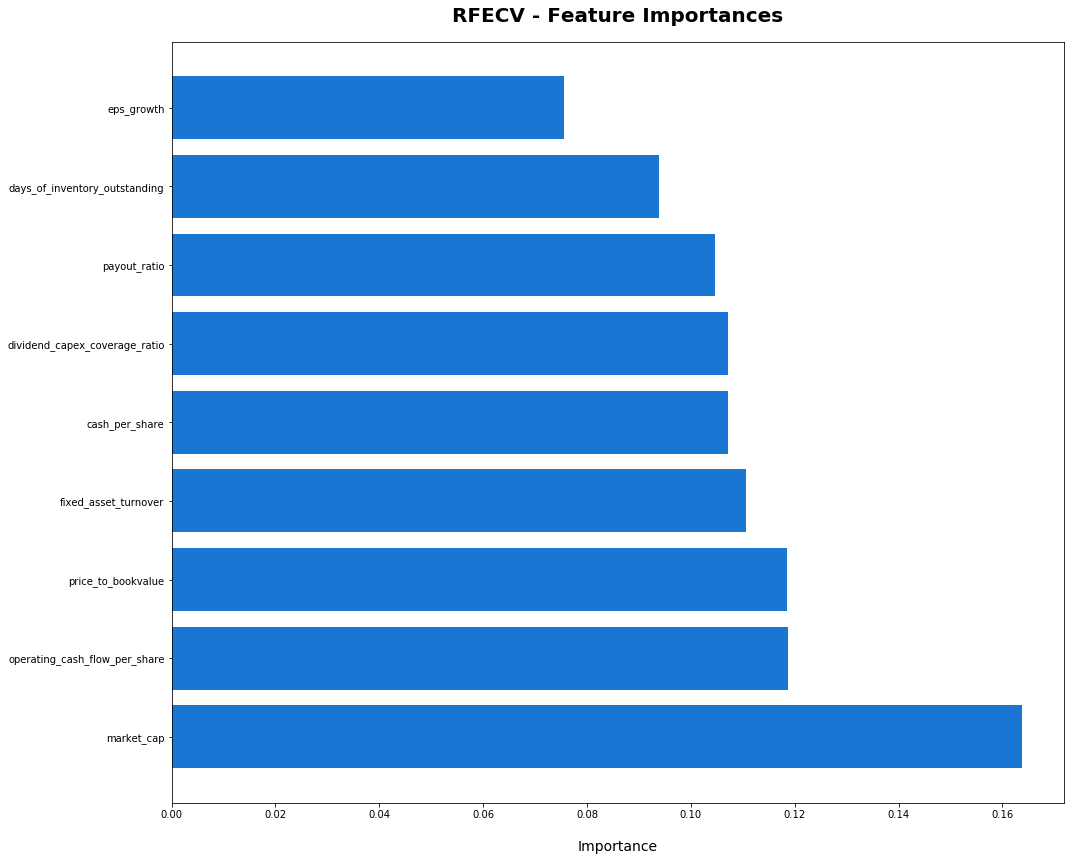

In [44]:
# visualizing the ranking of the features with a horizontal barchart.
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [45]:
X = sandp.drop('above_below_sandp_return', axis=1)
target = sandp['above_below_sandp_return']

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, target_train, target_test = train_test_split(X, target, random_state=1, stratify=target)

In [47]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
classifier.fit(X_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
print(f'Training Data Score: {classifier.score(X_train, target_train)}')
print(f'Testing Data Score: {classifier.score(X_test, target_test)}')

Training Data Score: 0.4472934472934473
Testing Data Score: 0.46153846153846156


In [50]:
predictions = classifier.predict(X_test)
pd.DataFrame({'Prediction': predictions, 'Actual': target_test}).reset_index(drop=True).head()

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0


In [51]:
target_test.value_counts()

1    65
0    52
Name: above_below_sandp_return, dtype: int64

In [52]:
target_test.value_counts()

1    65
0    52
Name: above_below_sandp_return, dtype: int64

In [53]:
target_train.value_counts()

1    193
0    158
Name: above_below_sandp_return, dtype: int64